In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from source.read_HAR_dataset import DatasetHARUML20
from source.read_pamap2 import DatasetPAMAP2
from source.read_open_dataset import DatasetOpenDataset
from source.tserie import TSerie
from source.models.manifold.umap_fl import UMAP_FL
from sklearn import metrics
from xgboost import XGBClassifier
from source.utils import MetricsSaver, saveConfusionMatrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from source.featlearn.simclr import SimClrFL
from sklearn import svm
from source.utils import minoritySampling
from scipy.fft import fft

sys.path.append('/home/texs/Documentos/Repositories/ts2vec')
from ts2vec import TS2Vec

/home/texs/anaconda3/envs/clearn/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
datasetName = 'PAMAP2' # PAMAP2 or HAR-UML20 or OpenDataset
FEATURE_SIZE = 32
# CLASS_LABELS = ['Sedentary', 'Light', 'Moderate', 'Vigorous']
UMAP_NEIGHTBORS = 15
N_EPOCHS = 2000
RESULTS_PATH = 'results'
BALANCE = False
USE_ACC_MAGNITUDE = False

USE_ACC= True
USE_GYR= False
USE_HR = True

MODE = 0 # 0 -> UMAP  -  1 -> TS2Vec - 2 -> SimCLR 
NET_EPOCHS = 6


In [3]:


if datasetName == 'PAMAP2':
    signals=['handAcc16_1', 'handAcc16_2', 'handAcc16_3', 'handGyro1', 'handGyro2', 'handGyro3', 'heartrate']
    # acc_signals = ['handAcc16_1', 'handAcc16_2', 'handAcc16_3']
    # signals=['handAcc16_1', 'handAcc16_2', 'handAcc16_3',]
    # signals=['handAcc16_1', 'handAcc16_2', 'handAcc16_3','heartrate']
    # signals=['heartrate']
    # heartrate
    dataset = DatasetPAMAP2(mode = 'leave-one-subject')
    
elif datasetName ==  'HAR-UML20':
    signals = ['Accelerometer-X', 'Accelerometer-Y', 'Accelerometer-Z', 'Gyrometer-X', 'Gyrometer-Y', 'Gyrometer-Z']
    dataset = DatasetHARUML20(mode = 'leave-one-subject')

elif datasetName == 'OpenDataset':
    signals = ['accelerometer_x', 'accelerometer_y', 'accelerometer_z', 'gyroscope_x', 'gyroscope_y', 'gyroscope_z', 'heart_rate']
    # signals = ['heart_rate']
    # signals = ['accelerometer_x', 'accelerometer_y', 'accelerometer_z']
    dataset = DatasetOpenDataset(mode = 'leave-one-subject')
    
CLASS_LABELS = dataset.intensities
if MODE == 0:
    MODEL_NAME = 'umap'
elif MODE == 1:
    MODEL_NAME = 'ts2vec'
elif MODE == 2:
    MODEL_NAME = 'simclr'

SENSORS = []

if USE_ACC:
    SENSORS.append('ACC')
if USE_GYR:
    SENSORS.append('GYR')
if USE_HR:
    SENSORS.append('HR')
SENSORS = '_'.join(SENSORS)

# saver = MetricsSaver(datasetName + '_PAI_{}'.format(MODEL_NAME), rows = ['test'], cols=['F1-score', 'Balanced Accuracy', 'Accuracy', 'Binary recall', 'Binary precision','Binary F1-score'])
saver = MetricsSaver(datasetName + '_PAI_{}_{}'.format(MODEL_NAME, SENSORS), rows = ['train', 'test'], cols=['F1-score', 'Balanced Accuracy', 'Accuracy'])

In [4]:
predicted_classes = []
real_classes = []
while dataset.loadData():
    dataset.filterSignals(signals)
    
    # Preparing data
    if BALANCE:
        dataset.X_train, dataset.Int_train = minoritySampling(dataset.X_train, dataset.Int_train)
    
    ts_train_acc = TSerie(dataset.X_train[:, :, :3], dataset.Int_train, I = dataset.I_train, dimensions=dataset.signals)
    ts_test_acc = TSerie(dataset.X_test[:, :, :3], dataset.Int_test, I = dataset.I_test, dimensions=dataset.signals)
    ts_train_gyr = TSerie(dataset.X_train[:, :, 3:6], dataset.Int_train, I = dataset.I_train, dimensions=dataset.signals)
    ts_test_gyr = TSerie(dataset.X_test[:, :, 3:6], dataset.Int_test, I = dataset.I_test, dimensions=dataset.signals)
    ts_train_hr = TSerie(np.expand_dims(dataset.X_train[:, :, 6], axis=2), dataset.Int_train, I = dataset.I_train, dimensions=dataset.signals)
    ts_test_hr = TSerie(np.expand_dims(dataset.X_test[:, :, 6], axis=2), dataset.Int_test, I = dataset.I_test, dimensions=dataset.signals)
    
    train_y = dataset.Int_train
    test_y = dataset.Int_test
    
    ts_train_acc.center()
    ts_test_acc.center()
    
    
    # minv, maxv = ts_train.minMaxNormalization()
    # minv, maxv = ts_test.minMaxNormalization(minl=minv, maxl=maxv)
    
    
    # ts_train.znorm()
    # ts_test.znorm()
    
    if USE_ACC_MAGNITUDE:
        ts_train_acc.features =  np.linalg.norm(ts_train_acc.X, axis=2)
        ts_test_acc.features = np.linalg.norm(ts_test_acc.X, axis=2)
        
    
    if MODE == 0:
        # Preparing data for model
        if not USE_ACC_MAGNITUDE:
            ts_train_acc.folding_features_v2()
            ts_test_acc.folding_features_v2()
        
        ts_train_gyr.folding_features_v2()
        ts_test_gyr.folding_features_v2()
        
        ts_train_hr.folding_features_v2()
        ts_test_hr.folding_features_v2()
        
        
        # Getting accelerometer features 
        train_features = []
        test_features = []
        if USE_ACC:
            model = UMAP_FL(n_components=FEATURE_SIZE, n_neighbors=UMAP_NEIGHTBORS, n_epochs=N_EPOCHS, metric='braycurtis')
            ts_train_acc.features = model.fit_transform(ts_train_acc.features, y=ts_train_acc.y)
            ts_test_acc.features = model.transform(ts_test_acc.features)
            train_features.append(ts_train_acc.features)
            test_features.append(ts_test_acc.features)
        
        # Getting gyroscope features 
        if USE_GYR:
            model = UMAP_FL(n_components=FEATURE_SIZE, n_neighbors=UMAP_NEIGHTBORS, n_epochs=N_EPOCHS, metric='braycurtis')
            ts_train_gyr.features = model.fit_transform(ts_train_gyr.features, y=ts_train_gyr.y)
            ts_test_gyr.features = model.transform(ts_test_gyr.features)
            train_features.append(ts_train_gyr.features)
            test_features.append(ts_test_gyr.features)
        
        # Getting heartrate features 
        if USE_HR:
            model = UMAP_FL(n_components=32,n_neighbors=UMAP_NEIGHTBORS, n_epochs=N_EPOCHS, metric='euclidean')
            ts_train_hr.features = model.fit_transform(ts_train_hr.features)
            ts_test_hr.features = model.transform(ts_test_hr.features)
            train_features.append(ts_train_hr.features)
            test_features.append(ts_test_hr.features)
        
        train_features = np.concatenate(train_features, axis=1)
        test_features = np.concatenate(test_features, axis=1)
        
    
    # elif MODE == 1:
    #     if USE_ACC_MAGNITUDE:
    #         model = TS2Vec(
    #             input_dims=1,
    #             device=0,
    #             output_dims=64,
    #             batch_size=4,
    #         )
    #         model.fit(ts_train.features, verbose=True,n_epochs = NET_EPOCHS)
    #         ts_train.features = model.encode(ts_train.features, encoding_window='full_series',batch_size=4,)
    #         ts_test.features = model.encode(ts_test.features, encoding_window='full_series',batch_size=4,)
    #     else:
    #         model = TS2Vec(
    #             input_dims=ts_train.D,
    #             device=0,
    #             output_dims=64,
    #             batch_size=4,
    #         )
    #         model.fit(ts_train.X, verbose=True,n_epochs = NET_EPOCHS)
    #         ts_train.features = model.encode(ts_train.X, encoding_window='full_series',batch_size=4,)
    #         ts_test.features = model.encode(ts_test.X, encoding_window='full_series',batch_size=4,)


        
    # Classifying
    clf = XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor')
    # clf = svm.SVC()
    clf.fit(train_features, train_y)
    train_pr = clf.predict(train_features)
    test_pr = clf.predict(test_features)
    predicted_classes.append(test_pr)
    real_classes.append(test_y)


    # Save metrics
    train_f1 = metrics.f1_score(train_y, train_pr, average='weighted')
    test_f1 = metrics.f1_score(test_y, test_pr, average='weighted')
    train_bacc = metrics.balanced_accuracy_score(train_y, train_pr)
    test_bacc = metrics.balanced_accuracy_score(test_y, test_pr)
    train_acc = metrics.accuracy_score(train_y, train_pr)
    test_acc = metrics.accuracy_score(test_y, test_pr)
    
    # train_y_bin = ts_train.y != 1
    # train_pred_bin = train_pr != 1
    
    # test_y_bin = ts_test.y != 1
    # test_pred_bin = test_pr != 1
    
    
    # test_rec = metrics.recall_score(test_y_bin, test_pred_bin)
    # test_prec = metrics.precision_score(test_y_bin, test_pred_bin)
    # test_f1 = metrics.f1_score(test_y_bin, test_pred_bin)
    
    
    
    saver.addLog('train', 'F1-score', train_f1)
    saver.addLog('test', 'F1-score', test_f1)
    saver.addLog('train', 'Balanced Accuracy', train_bacc)
    saver.addLog('test', 'Balanced Accuracy', test_bacc)
    saver.addLog('train', 'Accuracy', train_acc)
    saver.addLog('test', 'Accuracy', test_acc)
    

predicted_classes = np.concatenate(predicted_classes, axis = 0)
real_classes = np.concatenate(real_classes, axis = 0)


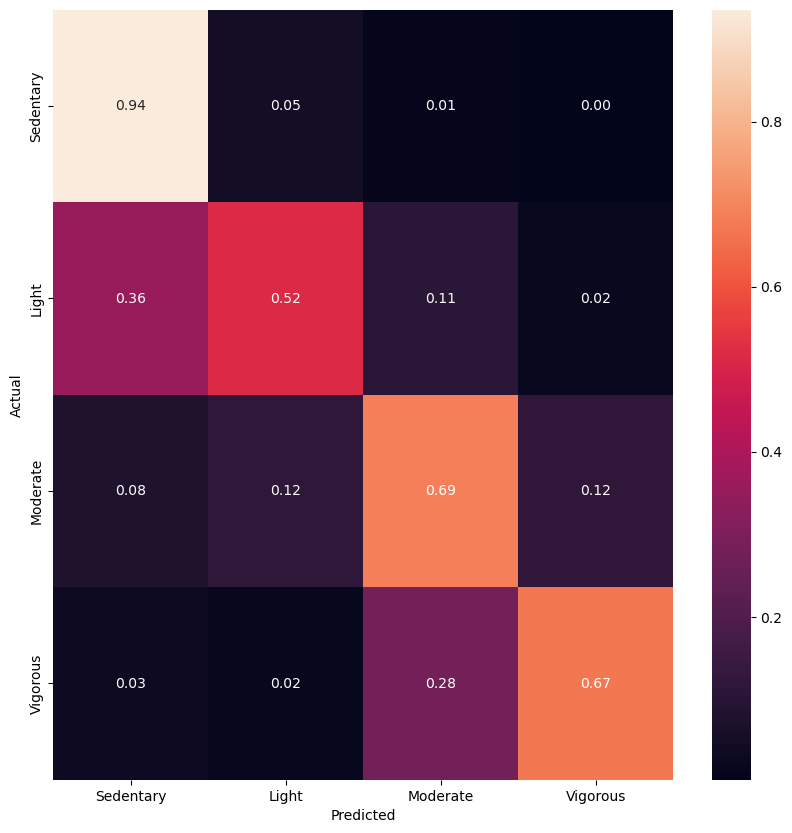

In [5]:

saveConfusionMatrix(real_classes, predicted_classes, datasetName + '_PAI_{}_{}'.format(MODEL_NAME, SENSORS), labels=CLASS_LABELS, xrotation=90)

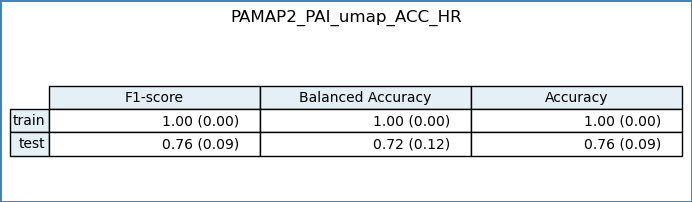

In [6]:
saver.toImage()